# Notebook Title <a class="tocSkip">

# Imports

## Import deps

Also check: https://github.com/xR86/ml-stuff/tree/master/scripts

In [1]:
import json
from pathlib import Path
from random import sample

# display libs
from IPython.display import display, HTML

from tqdm import tqdm, tqdm_notebook # !
tqdm.pandas()

SEED = 24

In [2]:
# https://stackoverflow.com/a/37124230
import uuid
from IPython.display import display_javascript, display_html, display
import json

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 100%; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)

In [46]:
import namesgenerator as ng

def build_human_readable_label_remapping(labels):
    mapping = {}

    for name in labels:
        while True:
            new_name = ng.get_random_name()
            if new_name not in mapping:
                mapping[name] = new_name
                break
    return mapping

build_human_readable_label_remapping(range(0,4))

{0: 'practical_galileo',
 1: 'festive_stallman',
 2: 'cocky_jepsen',
 3: 'keen_haibt'}

In [3]:
%%time

import numpy as np
import pandas as pd


# visualization libs
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import plotly.express as px

CPU times: user 783 ms, sys: 69.4 ms, total: 852 ms
Wall time: 1.39 s


In [4]:
import networkx as nx

import community as community_louvain

In [5]:
%%html
<style>

</style>

## Import data

In [6]:
emails = pd.read_csv('emails_cleaned.csv')
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
file                         10000 non-null object
payload                      10000 non-null object
Message_ID                   9999 non-null object
Date                         9999 non-null object
From                         9999 non-null object
To                           9670 non-null object
Subject                      8097 non-null object
Mime_Version                 9999 non-null float64
Content_Type                 9999 non-null object
Content_Transfer_Encoding    9999 non-null object
X_From                       9999 non-null object
X_To                         9861 non-null object
X_cc                         933 non-null object
X_bcc                        1 non-null object
X_Folder                     9999 non-null object
X_Origin                     9999 non-null object
X_FileName                   9999 non-null object
dtypes: float64(1), object(16)
memory usage

In [7]:
emails.head()

,file,payload,Message_ID,Date,From,To,Subject,Mime_Version,Content_Type,Content_Transfer_Encoding,X_From,X_To,X_cc,X_bcc,X_Folder,X_Origin,X_FileName
0,allen-p/_sent_mail/1.,Here is our forecast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,allen-p/_sent_mail/10.,Traveling to have a business meeting takes the...,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst
2,allen-p/_sent_mail/100.,test successful. way to go!!!,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
3,allen-p/_sent_mail/1000.,"Randy, Can you send me a schedule of the salar...",<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,NaN,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf
4,allen-p/_sent_mail/1001.,Let's shoot for Tuesday at 11:45.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf


In [8]:
emails.To.value_counts()

john.arnold@enron.com                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [9]:
clean_str = lambda string: string.replace('\n', '').replace('\t', '')

# .dropna(axis=0, how='any')\
emails.To = emails.To.fillna('')\
    .apply(lambda identities: identities.split(', '))

# Main

## Build graph

In [10]:
G = nx.DiGraph()

In [17]:
for i in range(len(emails)):
    node_from = emails.From.iloc[i]
    node_to   = []
    
    for recipient in emails.To.iloc[i]:
        node_to.append(recipient)
    
    if node_from == '' or node_to == ['']:
        continue
    
    G.add_node(node_from)
    for node in node_to:
        G.add_node(node)
        G.add_edge(node_from, node)

f'Generated graph with {len(G.nodes)} nodes and {len(G.edges)} edges.'

'Generated graph with 4921 nodes and 8489 edges.'

In [21]:
nodes = list(G.nodes())
samples = sample(nodes, 100)
G_sub = G.subgraph(samples)
f'Generated subgraph with {len(G_sub.nodes)} nodes and {len(G_sub.edges)} edges.'

'Generated subgraph with 100 nodes and 10 edges.'

CPU times: user 116 ms, sys: 44.1 ms, total: 160 ms
Wall time: 135 ms


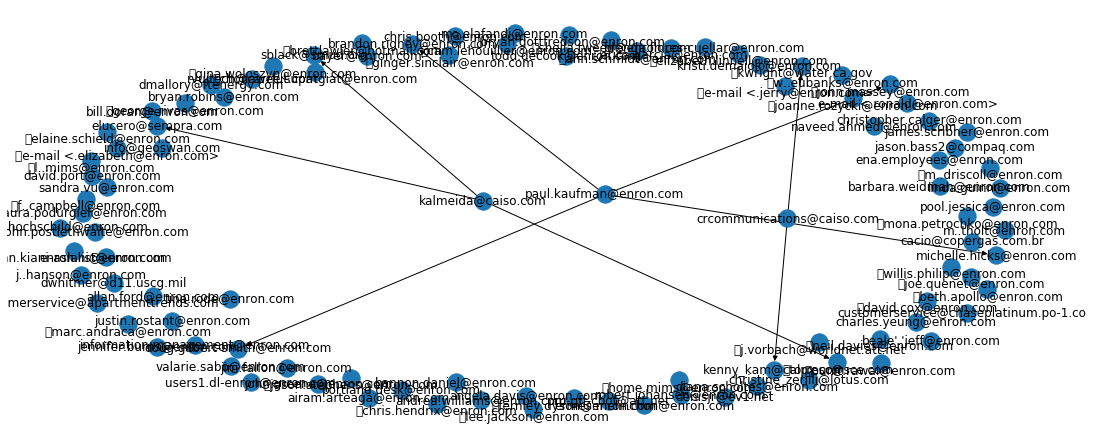

In [24]:
%%time
plt.figure(figsize=(15,6))
nx.draw(G_sub, with_labels=True)

## Louvain run

In [25]:
%%time
partition = community_louvain.best_partition(G.to_undirected(), random_state=SEED)

CPU times: user 585 ms, sys: 3.9 ms, total: 589 ms
Wall time: 593 ms


In [44]:
nx.set_node_attributes(G, partition, 'partition_name')

nodes = (
    node
    for node, data
    in G.nodes(data=True)
    if data.get('partition_name') == 19
)
# G_out = G
G_out = G.subgraph(nodes)

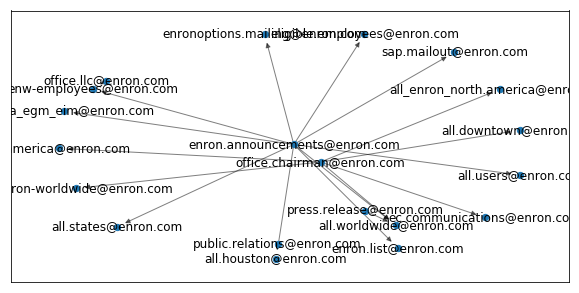

CPU times: user 474 ms, sys: 228 ms, total: 702 ms
Wall time: 351 ms


In [45]:
%%time
plt.figure(figsize=(10,5))

pos = nx.spring_layout(G_out)
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
# nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_nodes(G_out, pos, node_size=40)
nx.draw_networkx_edges(G_out, pos, alpha=0.5)
nx.draw_networkx_labels(G_out, pos=pos)

plt.show()

In [40]:
partition_df = pd.Series(partition).rename('partition_name').to_frame().rename_axis('person').reset_index()
partition_df.head()

,person,partition_name
0,phillip.allen@enron.com,30
1,john.lavorato@enron.com,1
2,leah.arsdall@enron.com,30
3,randall.gay@enron.com,30
4,greg.piper@enron.com,2


In [41]:
fig = px.histogram(partition_df, x='partition_name')
fig.show()

## Louvain multiresolution

In [48]:
%%time
partitions = []
# resolution = 1, default
resolutions = [0.2, 0.6, 1]

for resolution in resolutions:
    partition = community_louvain.best_partition(G.to_undirected(), resolution=resolution, random_state=SEED)
    partitions.append(partition)

CPU times: user 1.76 s, sys: 12 ms, total: 1.77 s
Wall time: 1.77 s


In [49]:
partition_dfs = {}

for resolution, partition in zip(resolutions, partitions):
    partition_df = pd.Series(partition).rename('partition_name').to_frame().rename_axis('person').reset_index()
    partition_df['partition_count'] = partition_df.groupby('partition_name').transform('count')
    
    partition_df.partition_name = partition_df.partition_name.replace(
        build_human_readable_label_remapping(partition_df.partition_name.unique())
    )
    
    partition_dfs[str(resolution)] = partition_df

In [57]:
temp = partition_dfs['0.2']
# temp[temp.partition_name == 'musing_noyce']

In [59]:
for resolution, partition_df in partition_dfs.items():
    display(HTML('<h1>Louvain run with resolution=<b>%s</b></h1>' % (
        resolution
    )))
    fig = px.histogram(partition_df, x='partition_name', nbins=10) # partition_count
    fig.show()

---

# Bibliography

---